In [30]:
import scipy.io as sio
import numpy as np
import mat73
import sklearn.cluster as  Clusterer
from sklearn.metrics import silhouette_score
from pyentrp import entropy as ent
import antropy as ant
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

## INPUT

In [3]:
def take_input(path):
    rawdata = mat73.loadmat(path)

    st = rawdata['stPwrLfpTex'].astype(np.float32)
    bl = rawdata['blPwrLfpTex'].astype(np.float32)
    freq = rawdata['freqVals'].astype(np.float32)
    electrode_names = rawdata['LFPElectrodes'].astype(np.int64)

    return st, bl, freq, electrode_names

path = "D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\Data\\simple_data_v1\\textureColorStimuliPowerSp_alpaH_st_250_500_bl_-250_0_summerProject.mat"
st, bl, freq, electrode_names = take_input(path)
change_in_power = np.zeros(shape=st.shape)
for i in range(st.shape[1]):
    change_in_power[:, i] = st[:, i] - bl
# array is reshaped so that first dimension is an image,second is frequency, third is electrode
change_in_power = np.transpose(change_in_power, (1, 2, 0))

## Functions to calculate Entropies and Clustering

In [4]:
def information(data, freq):
    # The input data is 2d samples*features, the goal is is to find the informational content of each feature
    entropies = np.zeros(shape=(3, data.shape[1]))
    for i in range(entropies.shape[1]):
        entropies[0][i] = ant.perm_entropy(data[:, i], normalize=True)
        entropies[1][i] = ant.app_entropy(data[:, i])
        entropies[2][i] = ant.svd_entropy(data[:, i])
    for i in range(len(entropies)):
        plt.plot(freq, entropies[i])
    plt.grid(which='both')
    plt.legend(["Permutation Entropy","Approximate Entropy"," SVD Entropy"])
    plt.show()

In [23]:
def cluster_grapher(k_vals, score_vals, name):
    # here we graph the scores for different values of k
    plt.plot(k_vals, score_vals)
    plt.grid(which='both')
    plt.title(name)
    plt.xlabel("No of Clusters")
    plt.ylabel("silhouette_score")
    plt.show()

def printer(kmeans_obj, score):
    print(round(score, 3), kmeans_obj.n_clusters, kmeans_obj.labels_)

def kmeans_best_k(data,show=False):
    if len(data.shape) > 2:
        data = np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2]))
    best_kmeans = None
    best_score = 0
    k_vals = range(2, 6)
    score_vals = np.zeros(len(k_vals))

    for no_clusters in k_vals:
        kmeans = Clusterer.KMeans(n_clusters=no_clusters).fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        score_vals[no_clusters - 2] = score
        # print(no_clusters, np.bincount(labels), score, kmeans.inertia_)
        if score > best_score:
            best_kmeans = kmeans
            best_score = score
    print("k_means",end='\t')
    printer(best_kmeans, best_score)
    if show:
        cluster_grapher(k_vals, score_vals, "KMeans")
    """bandwidth = Clusterer.estimate_bandwidth(data, quantile=0.2, n_samples=500)
    meanshift = Clusterer.MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(data)
    labels = meanshift.labels_
    score = silhouette_score(data, labels)
    printer(meanshift, score)"""

    return best_kmeans, best_score

def agglomerative_bestk(data,show=False):
    if len(data.shape) > 2:
        data = np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2]))
    best_agglomerative = None
    best_score_agglomerative = 0
    k_vals = range(2, 6)
    score_vals = np.zeros(len(k_vals))
    for no_clusters in k_vals:
        clustering = Clusterer.AgglomerativeClustering(n_clusters=no_clusters).fit(data)
        labels_agglomerative = clustering.labels_
        score_agglomerative = silhouette_score(data, labels_agglomerative)
        score_vals[no_clusters - 2] = score_agglomerative
        # print(no_clusters, np.bincount(labels), score, kmeans.inertia_)
        if score_agglomerative > best_score_agglomerative:
            best_agglomerative = clustering
            best_score_agglomerative = score_agglomerative
    print("k_means",end='\t')
    printer(best_agglomerative, best_score_agglomerative)
    if show:
        cluster_grapher(k_vals, score_vals, "Agglomerative")
    return best_agglomerative, best_score_agglomerative

def clustering_function(data,*,show=False):
    kmeans_obj, score = kmeans_best_k(data,show)
    aggl_obj,score=agglomerative_bestk(data,show)
    print("-\t-\t-\t-\n")
    return kmeans_obj,aggl_obj


### Clustering the entire data

In [24]:
clustering_function(change_in_power)

# now we take the average of electrodes and then we cluster the average
average_change_in_power = np.mean(change_in_power, axis=2)
clustering_function(average_change_in_power)

k_means	0.344 2 [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
k_means	0.344 2 [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0]
-	-	-	-

k_means	0.582 2 [0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0]
k_means	0.582 2 [0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0]
-	-	-	-



(KMeans(n_clusters=2), AgglomerativeClustering())

### Finding the Information per frequency

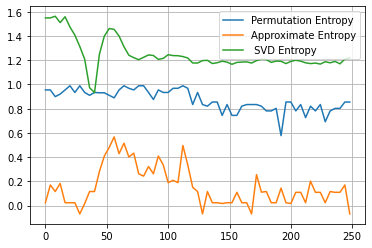

In [25]:
information(average_change_in_power, freq)

### Clustering based on Gamma frequency

k_means	0.568 2 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
k_means	0.521 2 [1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1]
-	-	-	-

k_means	0.699 2 [1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1]


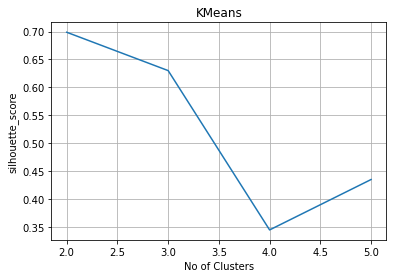

k_means	0.669 2 [1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1]


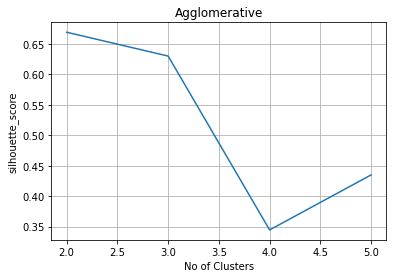

-	-	-	-



(KMeans(n_clusters=2), AgglomerativeClustering())

In [26]:
# based on this we say the most information is located in the  30-80  frequency band
# now we only take informative band i.e frequencies around 30-80hz which is the gamma band

gamma_band_change_in_power = change_in_power[:, np.logical_and(freq >= 30, freq <= 80), :]
clustering_function(gamma_band_change_in_power)

# now we only take gamma band i.e frequencies between 30-80Hz for average
gamma_band_change_in_power_avg = np.mean(gamma_band_change_in_power, axis=2)
clustering_function(gamma_band_change_in_power_avg,show=True)

## Visualising all images

In [32]:
path="D:\\OneDrive - Indian Institute of Science\\5th Sem\\Summer project\\Data\\simple_data_v1\\RGB_texture_images.mat"
raw_image_data = mat73.loadmat(path)
raw_images =(raw_image_data["images"]*255).astype(np.uint8)

for i in range (len(raw_images)):
    img = Image.fromarray(raw_images[i],'RGB')
    #display(img.show())